In [13]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
from util import random_mini_batches

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [14]:
from theano.tensor.shared_randomstreams import RandomStreams

In [15]:
class DenseLayer(object):
    
    def __init__(self, mi, mo, f = T.nnet.relu):
        
        self.W = theano.shared(np.random.randn(mi,mo)*2/np.sqrt(mi))
        self.b = theano.shared(np.zeros(mo))
        self.f = f
        
        self.params = [self.W,self.b]
    
    def forward(self, X):
        
        return self.f(X.dot(self.W)+self.b)

In [22]:
class VariationalAutoencoder:
    
    def __init__(self, D, hidden_layer_sizes):
        
        self.X = T.matrix('X')
        
        self.encoder_layers = []
        self.decoder_layers = []
        
        M_in = D
        
        for M_out in hidden_layer_sizes[:-1]:
            
            layer = DenseLayer(M_in,M_out)
            self.encoder_layers.append(layer)
            M_in = M_out
        
        M = hidden_layer_sizes[-1]
        
        final_enc_layer = DenseLayer(M_in, 2*M, f=lambda x:x)
        self.encoder_layers.append(final_enc_layer)
        
        
        
        current_layer_value = self.X
        
        for layer in self.encoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        
        self.means = current_layer_value[:,:M]
        self.stddev = T.nnet.softplus(current_layer_value[:,M:])+1e-6
        
        #get a sample of Z
        
        self.rng = RandomStreams()
        eps = self.rng.normal((self.means.shape[0],M))
        self.Z = self.means+self.stddev*eps
        
        self.decoder_layers = []
        M_in = M
        
        for M_out in reversed(hidden_layer_sizes[:-1]):
            
            layer = DenseLayer(M_in,M_out)
            self.decoder_layers.append(layer)
            M_in = M_out
        
        final_dec_layer = DenseLayer(M_in, D, f=T.nnet.sigmoid)
        self.decoder_layers.append(final_dec_layer)
        
        #posterior predictive
        current_layer_value = self.Z
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        
        self.posterior_predictive_probs = current_layer_value
        
        #take samples from X_hat
        #it's the posterior predictive sample
        
        self.posterior_predictive = self.rng.binomial(
            
            size=self.posterior_predictive_probs.shape,
            n=1,
            p=self.posterior_predictive_probs
        )
        
        #generate prior predictive sample
        Z_std = self.rng.normal((1,M))
        current_layer_value = Z_std
        
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        self.prior_predictive_probs = current_layer_value
        
        self.prior_predictive = self.rng.binomial(
        
            size = self.prior_predictive_probs.shape,
            n=1,
            p=self.prior_predictive_probs
        
        )
        
        #prior predictive from input
        #used for generating visualization
        
        Z_input = T.matrix('Z_input')
        current_layer_value = Z_input
        
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
            
        prior_predictive_probs_from_Z_input = current_layer_value
        
        #building the cost
        kl = -T.log(self.stddev) + 0.5*(self.stddev**2 + self.means**2) - 0.5
        
        kl = T.sum(kl, axis=1)
        
        expected_log_likelihood = -T.nnet.binary_crossentropy(
              output=self.posterior_predictive_probs,
              target=self.X,
        )
        
        expected_log_likelihood = T.sum(expected_log_likelihood, axis=1)
        
        self.elbo = T.sum(expected_log_likelihood - kl)
        
        params = []
        for layer in self.encoder_layers:
            params += layer.params
        for layer in self.decoder_layers:
            params += layer.params
    
        grads = T.grad(-self.elbo, params)

        # rmsprop
        decay = 0.9
        learning_rate = 0.001

        # for rmsprop
        cache = [theano.shared(np.ones_like(p.get_value())) for p in params]

        new_cache = [decay*c + (1-decay)*g*g for p, c, g in zip(params, cache, grads)]

        updates = [
            (c, new_c) for c, new_c in zip(cache, new_cache)
        ] + [
            (p, p - learning_rate*g/T.sqrt(new_c + 1e-10)) for p, new_c, g in zip(params, new_cache, grads)
        ]
        
        
        self.train_op = theano.function(
            inputs=[self.X],
            outputs=self.elbo,
            updates = updates
        )
        
        # returns a sample from p(x_new | X)
        self.posterior_predictive_sample = theano.function(
            inputs=[self.X],
            outputs=self.posterior_predictive
        )
        
        # returns a sample from p(x_new | z), z ~ N(0, 1)
        self.prior_predictive_sample_with_probs = theano.function(
            inputs=[],
            outputs=[self.prior_predictive, self.prior_predictive_probs]
        )

        # return mean of q(z | x)
        self.transform = theano.function(
            inputs=[self.X],
            outputs=self.means
        )
        
        
        # returns a sample from p(x_new | z), from a given z
        self.prior_predictive_with_input = theano.function(
            inputs=[Z_input],
            outputs=prior_predictive_probs_from_Z_input
        )
        
    def fit(self, X, epochs = 30, batch_sz=64):
            
            costs=[]
            n_batches = len(X) // batch_sz
            print("n_batches:", n_batches)
            
            for i in range(epochs):
                
                print("epoch:", i)
                np.random.shuffle(X)
                
                for j in range(n_batches):
                    
                    batch = X[j*batch_sz:(j+1)*batch_sz]
                    c = self.train_op(batch)
                    c /= batch_sz # just debugging
                    costs.append(c)
                
                    if j % 100 == 0:
                        print("iter: %d, cost: %.3f" % (j, c))
            plt.plot(costs)
            plt.show()        

In [ ]:
def test_vae():
    
    X_train = mnist.train.images
    #X_train = X_train/255
    X_train = (X_train>0.5).astype(np.float32)
    
    X_test = mnist.test.images
    #X_test = X_test/255
    X_test = (X_test>0.5).astype(np.float32)

    
    N, D = X_train.shape
    
    vae = VariationalAutoencoder(D,[200,100])
    vae.fit(X_train)
    
    #plot reconstruction
    done = False
    while not done:
        
        i = np.random.choice(len(X_test))
        x = X_test[i]
        im = vae.posterior_predictive_sample([x]).reshape(28, 28)
        
        plt.subplot(1,2,1)
        plt.imshow(x.reshape(28, 28), cmap='gray')
        plt.title("Original")
        
        plt.subplot(1,2,2)
        plt.imshow(im, cmap='gray')
        plt.title("Sampled")
        
        plt.show()

        ans = input("Generate another?")
        if ans and ans[0] in ('n' or 'N'):
            done = True

    # plot output from random samples in latent space
    done = False
    while not done:
        
        im, probs = vae.prior_predictive_sample_with_probs()
        im = im.reshape(28, 28)
        probs = probs.reshape(28, 28)
        
        plt.subplot(1,2,1)
        plt.imshow(im, cmap='gray')
        plt.title("Prior predictive sample")
        
        plt.subplot(1,2,2)
        plt.imshow(probs, cmap='gray')
        plt.title("Prior predictive probs")
        
        plt.show()

        ans = input("Generate another?")
        if ans and ans[0] in ('n' or 'N'):
            done = True
    

n_batches: 859
epoch: 0
iter: 0, cost: -1427.148
iter: 100, cost: -239.347
iter: 200, cost: -194.904
iter: 300, cost: -183.178
iter: 400, cost: -162.001
iter: 500, cost: -154.493
iter: 600, cost: -151.000
iter: 700, cost: -146.549
iter: 800, cost: -143.491
epoch: 1
iter: 0, cost: -150.738
iter: 100, cost: -134.781
iter: 200, cost: -140.844
iter: 300, cost: -135.378
iter: 400, cost: -141.630
iter: 500, cost: -143.435
iter: 600, cost: -125.572
iter: 700, cost: -132.120
iter: 800, cost: -131.600
epoch: 2
iter: 0, cost: -118.978
iter: 100, cost: -116.245
iter: 200, cost: -123.771
iter: 300, cost: -120.303
iter: 400, cost: -120.881
iter: 500, cost: -122.618
iter: 600, cost: -116.384
iter: 700, cost: -120.985
iter: 800, cost: -109.186
epoch: 3
iter: 0, cost: -113.666
iter: 100, cost: -118.199
iter: 200, cost: -120.358
iter: 300, cost: -118.755
iter: 400, cost: -107.472
iter: 500, cost: -113.899
iter: 600, cost: -107.514
iter: 700, cost: -107.751
iter: 800, cost: -106.762
epoch: 4
iter: 0, co

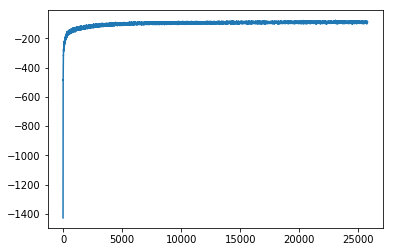

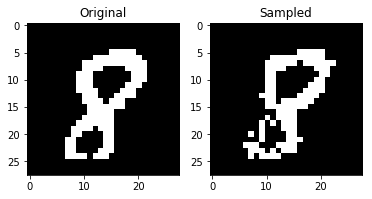

Generate another?


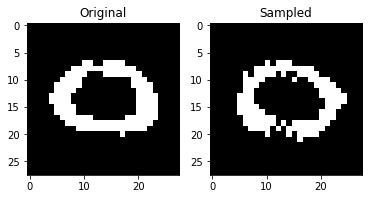

Generate another?


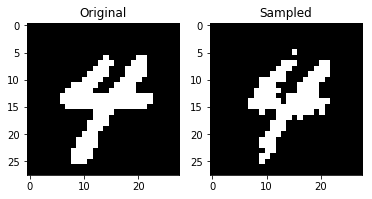

Generate another?


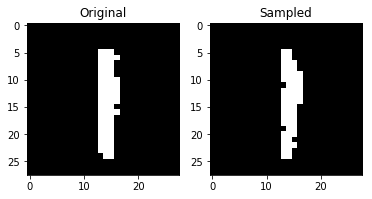

Generate another?n


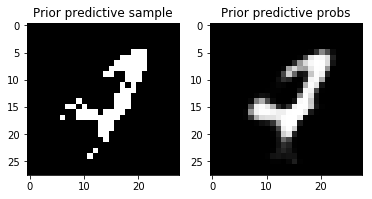

Generate another?


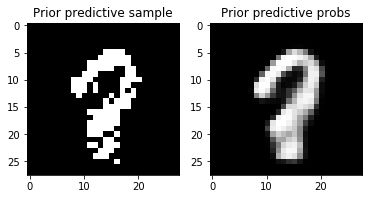

Generate another?


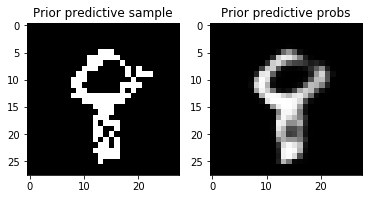

Generate another?


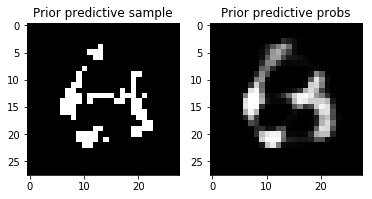

Generate another?


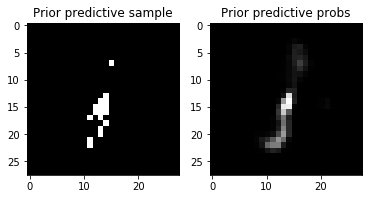

Generate another?


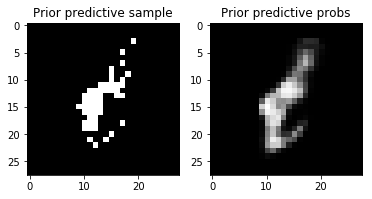

Generate another?


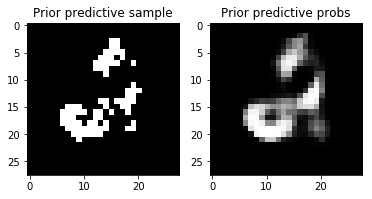

Generate another?


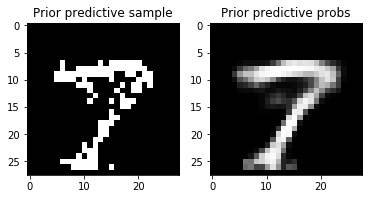

Generate another?


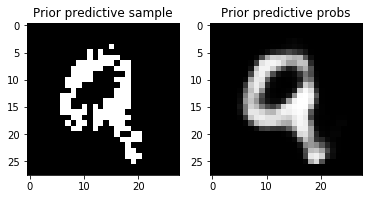

Generate another?


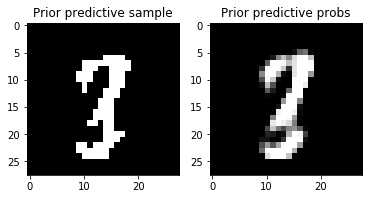

Generate another?


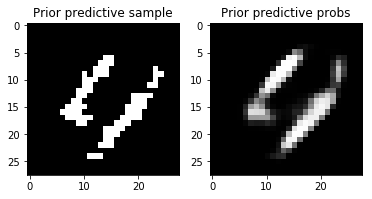

Generate another?


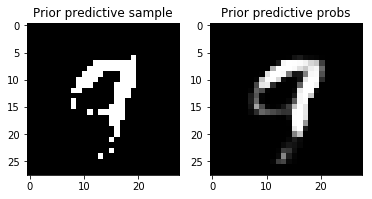

Generate another?


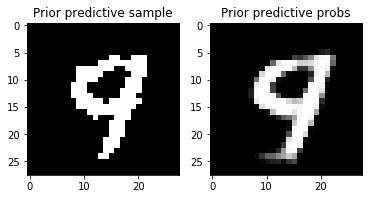

Generate another?


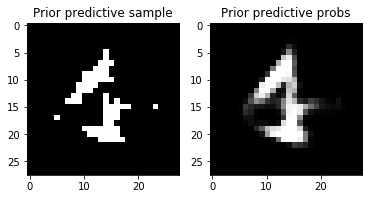

In [ ]:
if __name__=='__main__':
    test_vae()